### This notebook shows the creation and usage of an output node that is going to be used for inference
---
[1. Loading the needed functions via the pipeline](#step1)

[2. Create functions needed to create the inference function](#step2)

[3. Do inference using the function](#step3)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [80]:
from pathlib import Path
import sys
from pprint import pprint

import yaml
import numpy as np
sys.path.append("../../")

In [74]:
from pytorch_toolbox.pipeline import PipelineGraph
from src.train_with_template import lookups
from src.data import Image, match_prediction_probs_with_labels
from src.image import get_image_from_class, plot_rgby, get_unique_classes

#### 1. Loading the needed functions via pipeline <a id='step1'/>

In [5]:
CONFIG_FILE = Path("../configs/se_resnext50_32x4d_two_input_fc_template.yml")

In [6]:
with CONFIG_FILE.open("r") as f:
    config = yaml.load(f)

In [7]:
pipeline_graph = PipelineGraph.create_pipeline_graph_from_config(config)

In [8]:
pipeline_graph.sorted_node_names

['CreateLovaszHingeFlatLoss',
 'CreateSoftF1Loss',
 'CreateFocalLoss',
 'CreateF1SoftMetric',
 'CreateAccuracyMetric',
 'CreateModel',
 'CreateResultRecorder',
 'CreateGradientClippingLearnerCallback',
 'CreateLabelExtractorCallback',
 'CreateCallbacksForInference',
 'CreateLearnerForInference',
 'CreateCallbacks',
 'CreateTimeStampedSavePath',
 'RunRecordResults',
 'SaveConfiguration',
 'CreateCSVLoggerLearnerCallback',
 'CreateTrainingScheme',
 'CreateSamplerFunction',
 'CreateSampler',
 'CreateDenormalizeFunction',
 'CreateOutputRecorderLearnerCallback',
 'CreateLearnerCallbacks',
 'CreateLearner',
 'CreateNormalizeFunction',
 'CreateTestAugmentationFunction',
 'CreateAugmentationFunction',
 'CreateOpenImageFunction',
 'CreateTestingDataset',
 'CreateDataBunchForInference',
 'CreateInference',
 'CreateValidationDataset',
 'CreateTrainingDataset',
 'LoadTrainingData',
 'CreateDataSplitter',
 'LoadTestingData',
 'CreateDataBunch',
 'RunTrainingLoop']

##### 2. Create the functions needed to create the inference function <a id='step2'/>

In [9]:
pipeline_graph.run(reference_lookup=lookups, to_node="CreateInference")
create_inference_fn = pipeline_graph.get_node_output("CreateInference")

Uncomment to print out some classes from all the possible classes, pass None to get all the classes

In [81]:
unique_classes = get_unique_classes()
pprint(unique_classes)

[('Nuclear membrane', 'Nucleoli fibrillar center', 'Nuclear speckles'),
 ('Nucleoplasm', 'Nuclear speckles'),
 ('Nucleoplasm', 'Cytosol'),
 ('Nucleoplasm', 'Microtubule organizing center', 'Mitochondria'),
 ('Nucleoplasm', 'Nuclear bodies', 'Cytokinetic bridge', 'Cytosol'),
 ('Nucleoplasm', 'Nucleoli', 'Mitochondria'),
 ('Nucleoplasm', 'Nuclear membrane', 'Plasma membrane'),
 ('Plasma membrane', 'Cell junctions'),
 ('Nucleoplasm', 'Nuclear membrane', 'Actin filaments'),
 ('Nuclear membrane', 'Microtubule organizing center')]


In [87]:
image = get_image_from_class(('Plasma membrane', 'Cell junctions'))[0]

In [88]:
image.shape

(1024, 1024, 4)

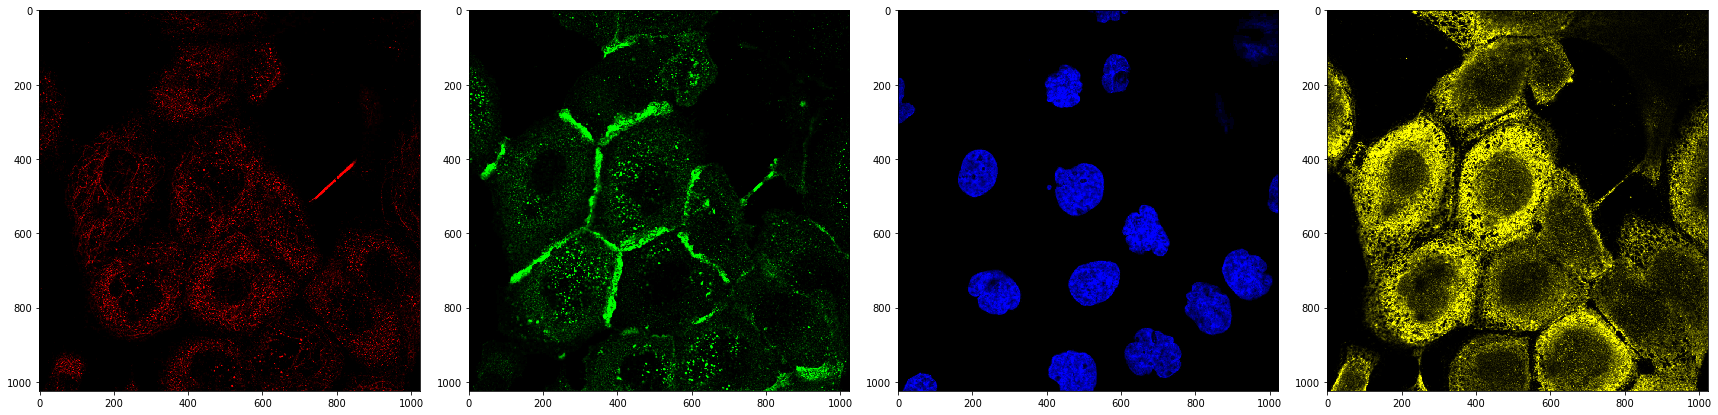

In [89]:
plot_rgby(image)

In [90]:
names, prediction_probs = create_inference_fn(image)

In [91]:
match_prediction_probs_with_labels(prediction_probs)

[('Cell junctions', 0.7177421),
 ('Plasma membrane', 0.7145914),
 ('Cytosol', 0.24149297),
 ('Nucleoplasm', 0.09981068),
 ('Focal adhesion sites', 0.080492124),
 ('Golgi apparatus', 0.07651401),
 ('Endoplasmic reticulum', 0.047597617),
 ('Cytokinetic bridge', 0.042523846),
 ('Nucleoli', 0.039671652),
 ('Nucleoli fibrillar center', 0.038626492),
 ('Nuclear speckles', 0.036774013),
 ('Actin filaments', 0.03101685),
 ('Microtubules', 0.026906664),
 ('Intermediate filaments', 0.024665011),
 ('Microtubule organizing center', 0.024212308),
 ('Centrosome', 0.024138467),
 ('Nuclear membrane', 0.023970278),
 ('Mitochondria', 0.022363322),
 ('Nuclear bodies', 0.021069344),
 ('Aggresome', 0.006073779),
 ('Cytoplasmic bodies', 0.004684954),
 ('Mitotic spindle', 0.0035193763),
 ('Lipid droplets', 0.0034543145),
 ('Peroxisomes', 0.002566355),
 ('Rods & rings', 0.0017126766),
 ('Endosomes', 0.001331684),
 ('Lysosomes', 0.0009995374),
 ('Microtubule ends', 0.00064126874)]